# Extended Kalman Filter design for bicycle's multibody dynamics simulation

In [1]:
# Import dependencies
from __future__ import division, print_function
%matplotlib inline

import scipy

from BicycleTrajectory2D import *
from BicycleUtils import *
from FormatUtils import *
from PlotUtils import *

from DatasetHelper import *
from DatasetImporter import *

## Load dataset

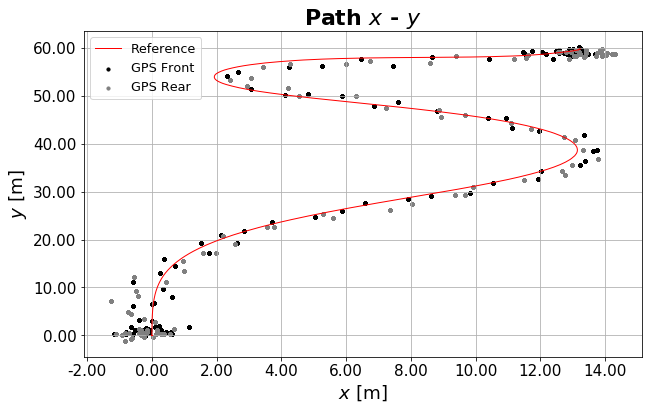

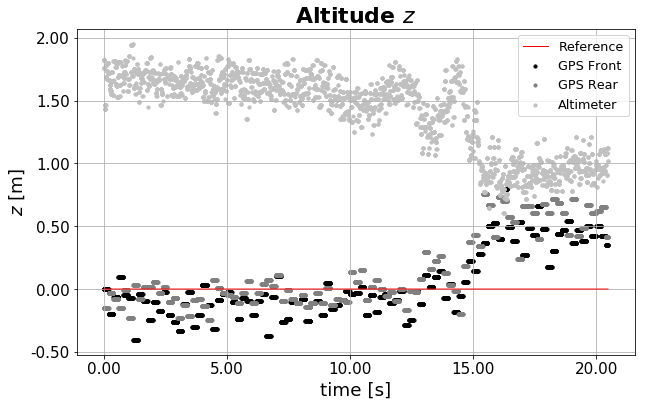

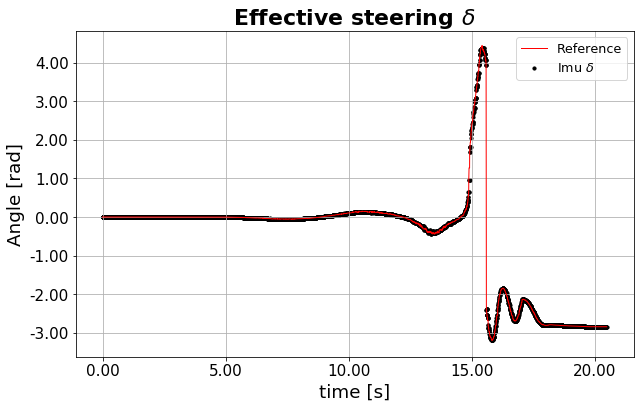

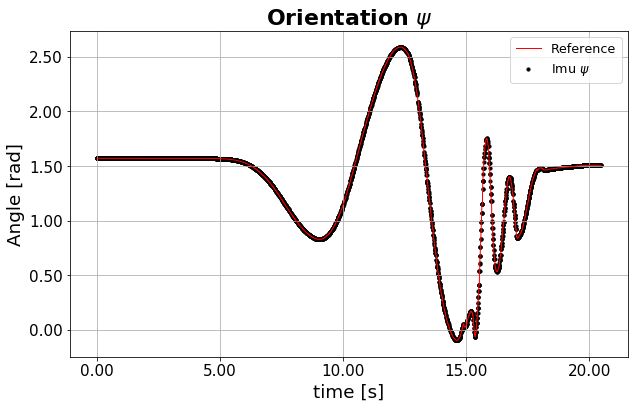

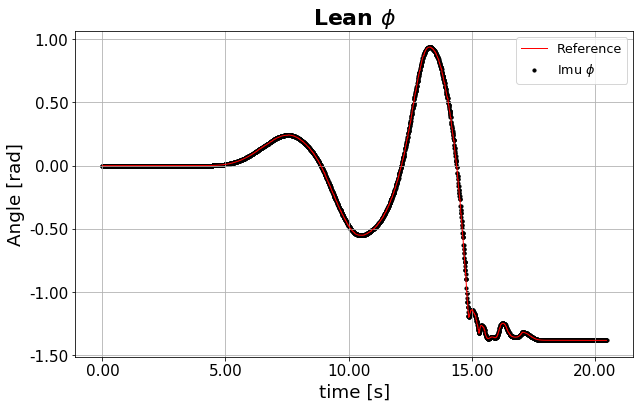

In [24]:
global_path = '../../bags/simulations/csv/'
#file_name = 'velocity_5/velocity_5_preprocessed.csv'
file_name = 'velocity_7/velocity_7_preprocessed.csv'
#file_name = 'velocity_8/velocity_8_preprocessed.csv'
#file_name = 'velocity_10/velocity_10_preprocessed.csv'

# Read dataset
data = pd.read_csv(global_path + file_name, index_col=0, parse_dates=True)
data['time_index'] = pd.to_datetime(data['time'])
data = data.set_index('time_index', drop=True, verify_integrity=True)
data['time'] = data.index
di = SimulationDatasetHelper(data)

# degree to radians conversion
di.data[di.gt_phi] = di.data[[di.gt_phi]]*np.pi/180.0
di.data[di.sim_phi] = di.data[[di.sim_phi]]*np.pi/180.0

di.data[di.gt_delta] = -di.data[[di.gt_delta]]*np.pi/180.0 
di.data[di.sim_delta] = -di.data[[di.sim_delta]]*np.pi/180.0

di.data[di.gt_psi] = di.data[[di.gt_psi]]*np.pi/180.0 + np.pi/2
di.data[di.sim_psi] = di.data[[di.sim_psi]]*np.pi/180.0 + np.pi/2

# select time: convert from pandas to numpy and fix initial offset
time = di.data[di.time].as_matrix()
time = time.astype('float64')/1e9
time = time - time[0]

# select state vector as reference (gt):
gt = di.data.filter(items=[di.gt_x, di.gt_y, di.gt_z, di.gt_delta, di.gt_psi, di.gt_phi]).as_matrix()

# select simulated measurements Z (sim):
sim = di.data.filter(items=[di.sim_xf, di.sim_xr, di.sim_yf, di.sim_yr,
                            di.sim_zf, di.sim_zr, di.sim_za,
                            di.sim_delta, di.sim_psi, di.sim_phi]).as_matrix()

# select imputs:
U = di.data.filter(items=[di.gt_v, di.angular_vel_delta, di.angular_vel_phi]).as_matrix()

# plot state variables
path_output_simulation =  'simulations/multibody_sim/' + file_name.split("/")[0] +'/'
    
plot_simulate_state_variables(gt=gt, sim=sim, time=time, file_name=path_output_simulation, 
                              scale_max=1.0, autoscale_axis=True)

## Implementation of EKF for $\sigma$-model

### Define state vector:

$$ X = 
\begin{bmatrix}x & y & z & v & \sigma & \psi & \phi \end{bmatrix}^\mathsf T$$

### Define measurement vector:

$$ Z = 
\begin{bmatrix}x_f & x_r & y_f & y_r & z_f & z_r & z_a & \sigma & \psi & \phi \end{bmatrix}^\mathsf T$$

In [25]:
class EKF_sigma_model_fusion(object):
    """Implements an EKF to bicycle model"""
    def __init__(self, xs, P, R_std, Q_std, wheel_distance=1.2, dt=0.1, alpha=1.0):
        self.w = wheel_distance        #Set the distance between the wheels
        self.xs = xs *0.0    #Set the initial state
        self.P = P      #Set the initial Covariance
        self.dt = dt
        self.R_std = R_std
        self.Q_std = Q_std
        self.alpha = alpha
        self.K = np.zeros((6, 6)) # Kalman gain
        #self.K = np.eye(6) # Kalman gain
        
        #Set the process noise covariance
        self.Q = np.diag([self.Q_std[0], # v
                          self.Q_std[1], # phi_dot
                          self.Q_std[2]  # delta_dot
                          ])
        
        # Set the measurement noise covariance
        self.R = np.diag([self.R_std[0],  # xf
                          self.R_std[1],  # xr
                          self.R_std[2],  # yf
                          self.R_std[3],  # yr
                          self.R_std[4],  # zf
                          self.R_std[5],  # zr
                          self.R_std[6],  # za
                          self.R_std[7],  # sigma
                          self.R_std[8],  # psi
                          self.R_std[9]]) # phi
        
        # Linear relationship H -  z = Hx
        self.H = np.zeros((10, 6))  # 10 measurements x 6 state variables
        [self.H[0, 0], self.H[1, 0]] = [1.0, 1.0]  # x
        [self.H[2, 1], self.H[3, 1]] = [1.0, 1.0]  # y
        [self.H[4, 2], self.H[5, 2], self.H[6, 2]] = [1.0, 1.0, 1.0]  # z
        [self.H[7, 3], self.H[8, 4], self.H[9, 5]] = [1.0, 1.0, 1.0]  # sigma - psi - phi
        
    def Fx(self, xs, u):
        """ Linearize the system with the Jacobian of the x """
        F_result = np.eye(len(xs))
        
        v = u[0]
        phi_dot = u[1]
        delta_dot = u[2]
        
        sigma = xs[3]
        psi = xs[4]
        phi = xs[5]
        t = self.dt

        F04 = -t * v * np.sin(psi) 
        F14 = t * v * np.cos(psi)
        F33 = (2 * t * delta_dot * sigma * self.w) + 1
        F43 = (t * v)/np.cos(phi)
        F45 = t * sigma * v * np.sin(phi) / np.cos(phi)**2

        F_result[0, 4] = F04
        F_result[1, 4] = F14
        F_result[3, 3] = F33
        F_result[4, 3] = F43
        F_result[4, 5] = F45

        return F_result
    
    def Fu(self, xs, u):
        """ Linearize the system with the Jacobian of the u """
        v = u[0]
        phi_dot = u[1]
        delta_dot = u[2]
        
        sigma = xs[3]
        psi = xs[4]
        phi = xs[5]
        t = self.dt
        
        V_result = np.zeros((len(xs), len(u)))
        
        V00 = t * np.cos(psi)
        V10 = t * np.sin(psi)
        V32 = (t/self.w)*((sigma**2)*(self.w**2) + 1)
        V40 = t * sigma / np.cos(phi)
        V51 = t

        V_result[0, 0] = V00
        V_result[1, 0] = V10
        V_result[3, 2] = V32
        V_result[4, 0] = V40
        V_result[5, 1] = V51

        return V_result
    
    def f(self, xs, u):
        """ Estimate the non-linear state of the system """
        v = u[0]
        phi_dot = u[1]
        delta_dot = u[2]
        
        sigma = xs[3]
        psi = xs[4]
        phi = xs[5]
        t = self.dt
               
        fxu_result = np.zeros((len(xs), 1))
        
        fxu_result[0] = xs[0] + t * v * np.cos(psi)
        fxu_result[1] = xs[1] + t * v * np.sin(psi)
        fxu_result[2] = xs[2]
        fxu_result[3] = xs[3] + (t*phi_dot/self.w)*((sigma**2)*(self.w**2) +1)
        fxu_result[4] = xs[4] + t * v * sigma / np.cos(phi)
        fxu_result[5] = xs[5] + t * phi_dot
        
        return fxu_result

    def h(self, x):
        """ takes a state variable and returns the measurement
        that would correspond to that state. """   
        sensor_out = np.zeros((10, 1))
        sensor_out[0] = x[0]
        sensor_out[1] = x[0]
        sensor_out[2] = x[1]
        sensor_out[3] = x[1]
        sensor_out[4] = x[2]
        sensor_out[5] = x[2]
        sensor_out[6] = x[2]
        sensor_out[7] = x[3] # sigma
        sensor_out[8] = x[4] # psi
        sensor_out[9] = x[5] # phi
        
        return sensor_out

    def Prediction(self, u):
        x_ = self.xs
        P_ = self.P
        self.xs = self.f(x_, u)
        self.P = self.alpha * self.Fx(x_, u).dot(P_).dot((self.Fx(x_,u)).T) + \
             self.Fu(x_,u).dot(self.Q).dot((self.Fu(x_,u)).T)
    
    def Update(self, z):
        """Update the Kalman Prediction using the meazurement z"""
        y = z - self.h(self.xs)
        self.K = self.P.dot(self.H.T).dot(np.linalg.inv(self.H.dot(self.P).dot(self.H.T) + self.R))
        
        self.xs = self.xs + self.K.dot(y)
        self.P = (np.eye(len(self.xs)) - self.K.dot(self.H)).dot(self.P)

In [26]:
[t, wheel_distance, number_state_variables] = [0.0, 1.1, 6]

X_init = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  # [x, y, z, sigma, psi, phi]

zs_gt = di.data[[di.gt_x, di.gt_y, di.gt_z, di.gt_delta, di.gt_psi, di.gt_phi]].as_matrix()
zs_sim = di.data[[di.sim_xf, di.sim_xr, di.sim_yf, di.sim_yr, 
                  di.sim_zf, di.sim_zr, di.sim_za,
                  di.sim_delta, di.sim_psi, di.sim_phi]].as_matrix()
u_sim = di.data[[di.sim_v, di.angular_vel_phi, di.angular_vel_delta]].as_matrix()
time_t = di.data[[di.time]].as_matrix()

alpha = 1.0

# covariance matrix
P = np.eye(number_state_variables) * 10

dt = 1.0/5.0 # Slower Sample Rate of the Measurements is 5Hz

# defining how bad things may goes, take max acceleratin value x margin
margin = 1

# Input noise covariance M -----------------------------------------------------------------------
# Maximum change (acceleration) for given dataset
max_acc_v = float(di.data[[di.sim_v]].diff().max()) * margin
max_acc_phi_dot = float(di.data[[di.angular_vel_phi]].diff().max()) * margin
max_acc_delta_dot = float(di.data[[di.angular_vel_delta]].diff().max()) * margin

sigma_v = (max_acc_v*dt)**2
sigma_phi_dot = (max_acc_phi_dot*dt)**2
sigma_delta_dot = (max_acc_delta_dot*dt)**2

# print("sigma", [sigma_v, sigma_phi_dot,sigma_delta_dot])

M_std = [sigma_v, sigma_phi_dot,sigma_delta_dot] # v, phi_dot, delta_dot

# measurement noise covariance R ---------------------------------------------------------------------
R_std = [0.5**2, 0.5**2,  # x
         0.5**2, 0.5**2,  # y
         0.5**2, 0.5**2, 0.5**2,  # z
         0.5**2, 0.02**2, 0.08**2] # delta - psi - phi

#[offset_psi, offset_phi, offset_delta] = [-1.0, 0.0, 0.05]
[offset_psi, offset_phi, offset_delta] = [0.0, 0.0, 0.0]

filter_ekf = EKF_sigma_model_fusion(X_init, P, R_std=R_std, Q_std=M_std, wheel_distance=wheel_distance, dt=dt, alpha=alpha)

U = np.array([0.0, 0.0, 0.0]) # [v, phi_dot, delta_dot]

xs = np.zeros((len(time_t), number_state_variables))
ps = np.zeros((len(time_t), number_state_variables, number_state_variables))
PU = np.zeros((len(time_t), number_state_variables))
KU = np.zeros((len(time_t), number_state_variables))
z_t = np.zeros((10, 1))
t = range(1, len(time_t))
z = zs_sim

Q_scale_factor = 1.0
eps_max = 17.0
count = 0
epss = range(0, len(time_t))
dt_real = dt
for i in range(1, len(time_t)): 
    if i > 1:
        dt_real = float(time_t[i] - time_t[i-1])/1e9 # time: nano to seg
        
    filter_ekf.dt = dt_real
    
    P = filter_ekf.P
    K = filter_ekf.K
    PU[i] = [P[0,0], P[1,1], P[2,2], P[3,3], P[4,4], P[5,5]]
    KU[i] = [K[0,0], K[1,1], K[2,2], K[3,3], K[4,4], K[5,5]]
    xs[i] = filter_ekf.xs.T
    
    # update U
    U[0] = float(u_sim[i, 0])
    U[1] = float(u_sim[i, 1])
    U[2] = float(u_sim[i, 2])
    
    # predict
    filter_ekf.Prediction(U)

    #Update measurements [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
    z_t[0] = z[i, 0] # xf
    z_t[1] = z[i, 1] # xr
    z_t[2] = z[i, 2] # yf
    z_t[3] = z[i, 3] # yr
    z_t[4] = z[i, 4] # zf
    z_t[5] = z[i, 5] # zr
    z_t[6] = z[i, 6] # za
    z_t[7] = np.tan(z[i, 7])/wheel_distance  # sigma
    z_t[8] = z[i, 8]  # psi
    z_t[9] = z[i, 9]  # phi

    filter_ekf.Update(z_t)

# update delta based on sigma
xs[:, 3] = np.arctan2(xs[:, 3], 1/wheel_distance) # delta

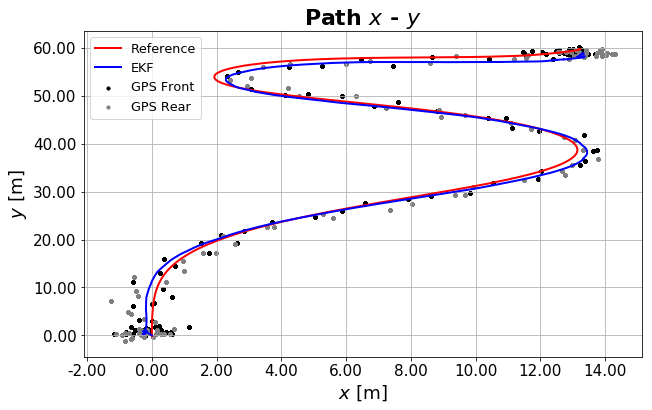

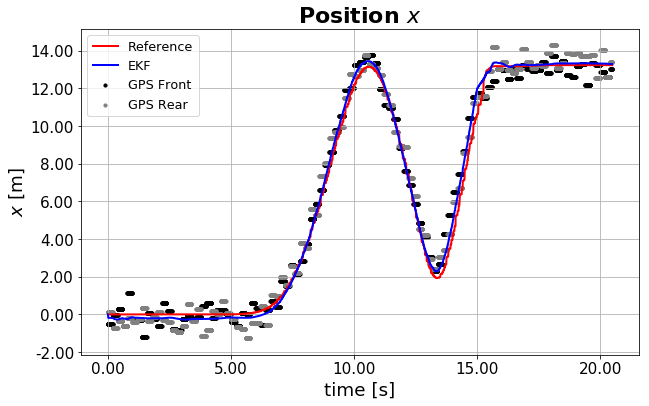

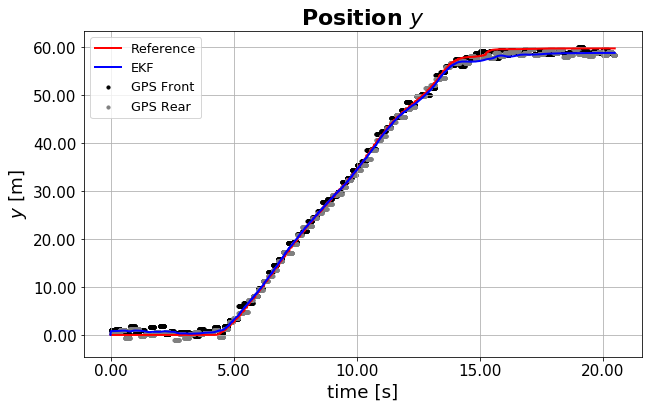

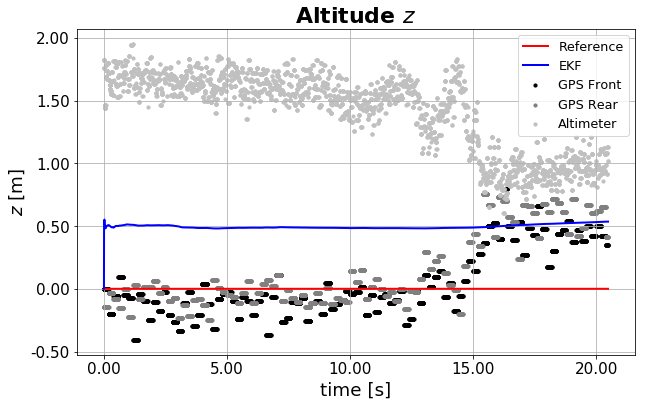

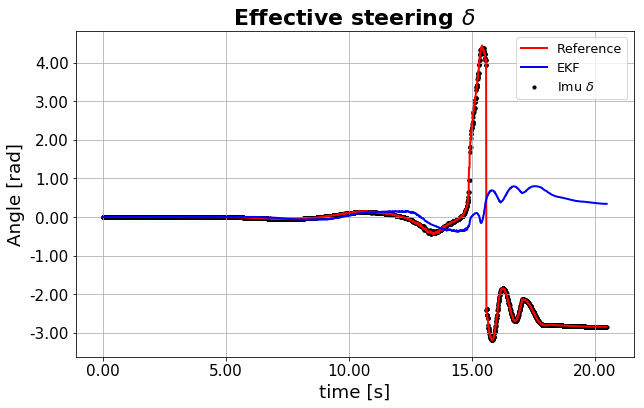

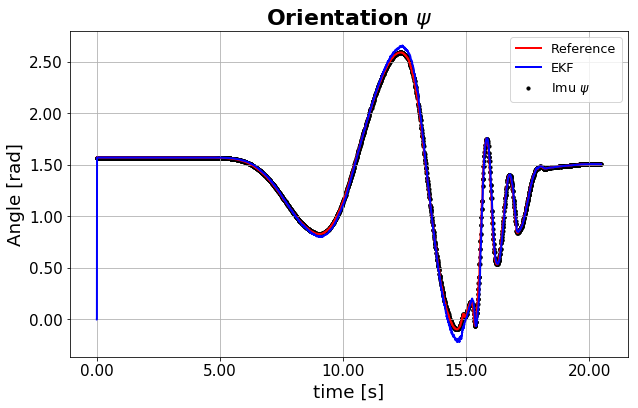

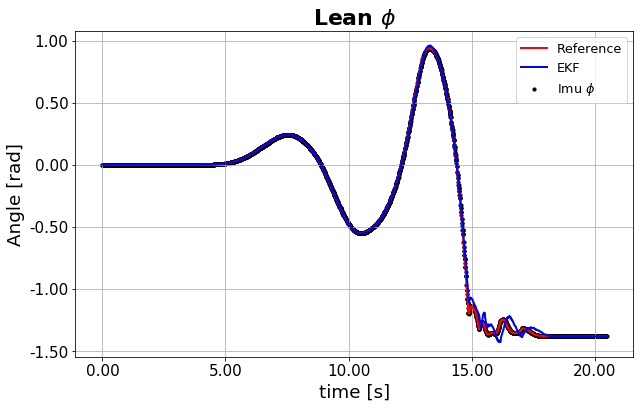

In [27]:
filter_name = 'EKF'
path_output_filter = 'filters/EKF/multibody_sim/' + file_name.split("/")[0] + "/"
plot_filter_results(xs, zs_gt, zs_sim, time, path_output_filter, filter_name, autoscale_axis=True)

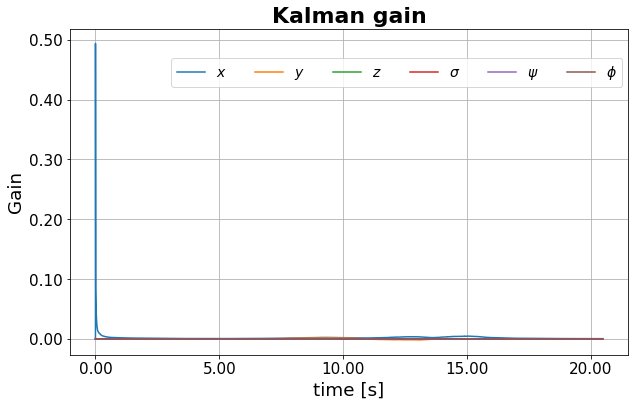

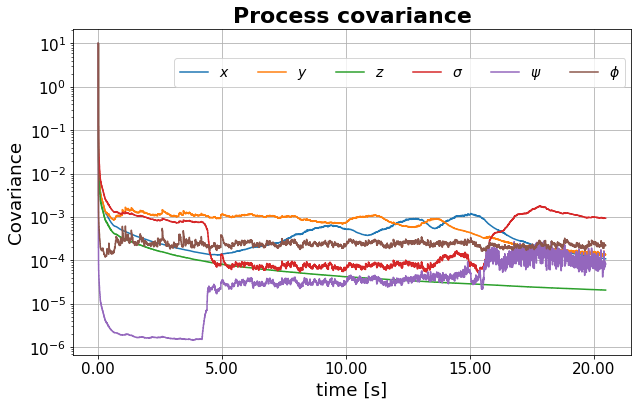

In [28]:
plot_EKF_gain_covariance(time, KU, PU, path_output_filter, autoscale_axis=True)